In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import caiman as cm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
%matplotlib inline
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

## 1. Load data after pixel denoise and motion correction
see notebook `pixelNoise_motionCorrection_v1`

In [3]:
imgStack = np.load('tmpData/imgDMotion.npy')
Y = np.asarray(imgStack)
Y = Y.transpose([1,2,0])

## 2. Detrend raw signal on pixels

In [4]:
# from spatialDenoising.preprocess import detrend # default order = 3
# stim = None
# disc = None
# Y_detr, trend, _, _ = detrend(Y, stim, disc) # this could be speed up using mp....
# np.save('tmpData/Y_detr', Y_detr)
# np.save('tmpData/Y_trend', trend)

In [5]:
Y_detr = np.load('tmpData/Y_detr.npy')
trend = np.load('tmpData/Y_trend.npy')
mov = np.asarray(Y_detr,order='C',dtype=np.float64)
mov = (mov - mov.mean(axis=-1)[:, :, np.newaxis])/mov.std(axis=-1)[:, :, np.newaxis] #np.sqrt(mov.var(axis=-1)+1)[:, :, np.newaxis]

## 3 Spatial denoising using patched SVD (Greedy algorithm)

In [6]:
# from spatialDenoising.denoise import temporal as svd_patch
# nblocks=[12,12]
# dx=4
# maxlag=5
# confidence=0.99
# greedy=False,
# fudge_factor=1
# mean_th_factor=1.15
# U_update=False
# min_rank=1
# stim_knots=None
# stim_delta=0

In [7]:
# %%time
# Y_svd, ranks = svd_patch(mov, nblocks=nblocks, dx=dx, stim_knots=stim_knots, stim_delta=stim_delta)

In [8]:
dat_ = np.load('tmpData/Y_denoised_svd.npz')
Y_amp = dat_['Y_amp']
Y_ave = dat_['Y_ave']
Y_svd = dat_['Y_svd']
ave_trend = dat_['ave_trend']

## 3.1 Examining the denoise performance
### 3.1.1 Denoised images vs raw image

In [9]:
tmp_ = [mov, Y_svd, mov-Y_svd]
titles = ['Raw data', 'Local sPCA', 'Residual']
movie_ = ['Raw_data', 'Local_sPCA', 'Residual']

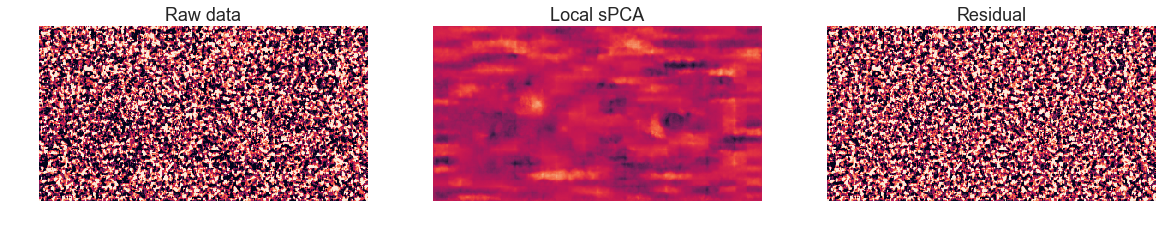

In [10]:
f, ax = plt.subplots(1, len(tmp_), figsize=(20, 5))
for nPlt in range(len(tmp_)):
    cf = ax[nPlt].imshow(tmp_[nPlt][:,:,0], vmax = 1, vmin=-1)
    ax[nPlt].set_title(titles[nPlt])
    ax[nPlt].axis('off')
plt.show()

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation

mov_detrend = -np.load('tmpData/Y_detr.npy')
mov_min = mov_detrend.min(axis=-1, keepdims=True)
mov_denoise = -(Y_svd * Y_amp + Y_ave)
mov_min_ = mov_denoise.min(axis=-1, keepdims=True)
mov_noise = mov_detrend - mov_denoise

In [26]:
d1, d2, _ = mov.shape

In [38]:
movs = [mov_detrend-mov_min, mov_denoise-mov_min_, mov_noise]
titles = ['Detrend', 'Denoised', 'Noise']
max_ = [np.percentile(_, 99) for _ in movs]
min_ = [np.percentile(_, 1) for _ in movs]
# max_[1] = 1*3
# min_[1] = -1

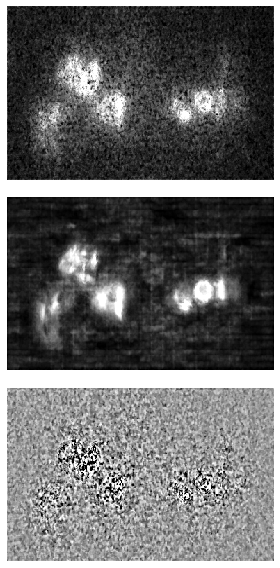

In [39]:
fig, axs = plt.subplots(3,1, figsize=(4, 8))

for mdx in range(3):
#     axs[mdx].set(title=titles[mdx])
#     axs[mdx].title.set_fontsize(15)
#     axs[mdx].title.set_fontweight("bold")
    axs[mdx].set_axis_off()
    axs[mdx].set_xticklabels([])
    axs[mdx].set_yticklabels([])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)

imgs = [ax.imshow(movs[mdx][:,:, 0], vmin=min_[mdx], vmax=max_[mdx], cmap="Greys_r", aspect='auto') for mdx, ax in enumerate(axs)]

In [40]:
from matplotlib.animation import FFMpegFileWriter
def update(i):
    for mdx in range(3):
        imgs[mdx].set_data(movs[mdx][:,:,i]);
    return imgs

num_frames = 1200 #mov.shape[-1]
fps = 60
filename = 'tmpMovie/02212018Fish2-1_lpca.mp4'
ani = animation.FuncAnimation(fig, update, frames=num_frames, blit=True);
mywriter = FFMpegFileWriter(fps=fps,codec="h264")
ani.save(filename, writer=mywriter)

### 3.1.2 SNR

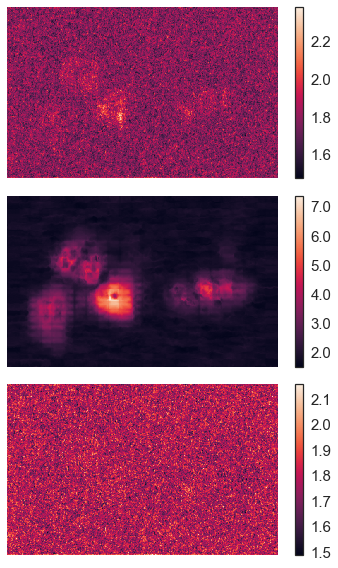

In [17]:
titles = ['Detrended raw data', 'Denoised', 'Noise']
f, ax = plt.subplots(len(tmp_), 1, figsize=(5, 8))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    mean_ = Y_.mean(axis=2,keepdims=True)
    sn, psdx = cm.source_extraction.cnmf.pre_processing.get_noise_fft(Y_ - mean_,noise_method='logmexp')
    SNR_ = Y_.var(2)/sn**2
    cf = ax[nPlt].imshow(SNR_, aspect='auto') #, vmin=0.1, vmax=0.9, np.log(SNR_)
#     ax[nPlt].set(title=titles[nPlt])
#     ax[nPlt].title.set_fontsize(15)
#     ax[nPlt].title.set_fontweight("bold")
    ax[nPlt].set_axis_off()
    ax[nPlt].set_xticklabels([])
    ax[nPlt].set_yticklabels([])
    f.colorbar(cf, ax=ax[nPlt], format='%.01f')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

### 3.1.3 Local correlations

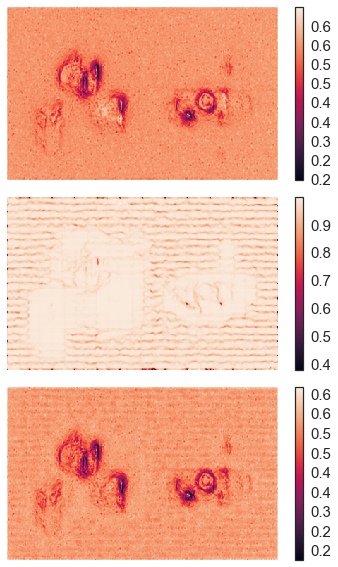

In [19]:
f, ax = plt.subplots(len(tmp_), 1, figsize=(5, 8))
for nPlt in range(len(tmp_)):
    Y_ = tmp_[nPlt]
    cf = ax[nPlt].imshow(cm.local_correlations(Y_), aspect='auto') #, vmin=0, vmax=1
#     ax[nPlt].set(title=titles[nPlt])
#     ax[nPlt].title.set_fontsize(15)
#     ax[nPlt].title.set_fontweight("bold")
    ax[nPlt].set_axis_off()
    ax[nPlt].set_xticklabels([])
    ax[nPlt].set_yticklabels([])
    f.colorbar(cf, ax=ax[nPlt], format='%.01f')
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.show()

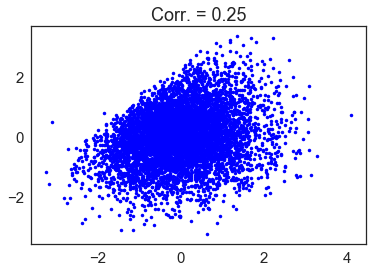

0.2342712


In [15]:
mov_r = mov-Y_svd
loc = [131, 253]
plt.plot(mov_r[loc[0], loc[1], :], mov_r[loc[0]+1, loc[1]+1, :], '.b')
# plt.plot(mov[loc[0], loc[1], :], mov[loc[0]+1, loc[1]+1, :], '.r')
plt.title('Corr. = %0.2f'%(np.corrcoef(mov_r[loc[0], loc[1], :], mov_r[loc[0]+1, loc[1]+1, :])[0,1]))
plt.show()
print(Cn[loc[0], loc[1]])

## 3.2 Saving data

In [17]:
np.savez('tmpData/Y_denoised_svd', 
         Y_amp = Y_detr.std(axis=-1)[:, :, np.newaxis], 
         Y_ave = Y_detr.mean(axis=-1)[:, :, np.newaxis], 
         Y_svd = Y_svd,
         ranks = ranks,
         ave_trend = trend.mean(axis=-1)[:, :, np.newaxis])